In [1]:
import numpy as np
import pandas as pd

def Peaks(x, y):
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return z

def GetGrid(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = Peaks(x, y)
    return x, y, z

def create_dataframe(grid):
   x, y, z = GetGrid(grid)
   data = {'x1': x.flatten(), 'x2': y.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Gaussian")

/tmp/ipykernel_990309/3623673326.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


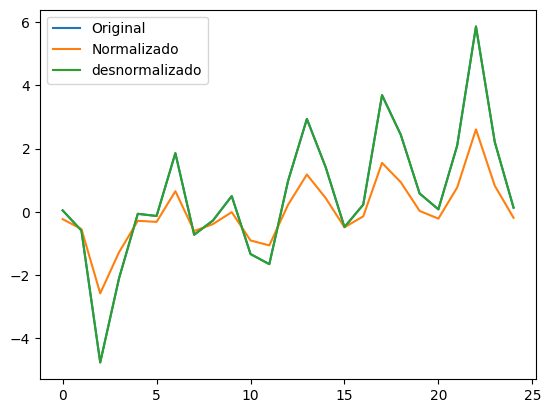

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.


remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 16.50 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-08-25 02:29:54.801384: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 02:29:54.849733: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-25 02:29:54.849776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-25 02:29:54.851073: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-25 02:29:54.859021: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-25 02:29:54.860155: I tensorflow/core/platform/cpu_feature_guard.cc:1

2024-08-25 02:29:56.306791: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-weights.keras')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-weights.keras",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 1s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_4,0.935449,0.738866,0.720027,0.912566,0.279488,1.746204,1.001447,0.295396,0.674757,0.528666,5.131237,0.536992,132.549593,273.884765
model_1_2_3,0.925456,0.721992,0.721497,0.916564,0.322757,1.859038,0.996188,0.281888,0.580614,0.568117,5.770822,0.577065,132.261710,273.596882
model_1_2_2,0.925917,0.721651,0.724403,0.921918,0.320760,1.861324,0.985794,0.263797,0.551710,0.566356,5.741293,0.575276,132.274127,273.609299
model_1_2_1,0.901057,0.699583,0.726291,0.869579,0.428396,2.008888,0.979041,0.440625,0.628397,0.654520,7.332323,0.664828,131.695413,273.030585
model_1_2_0,0.887274,0.690724,0.701877,0.833837,0.488076,2.068132,1.066367,0.561378,0.710785,0.698624,8.214472,0.709627,131.434569,272.769741


DataFrame salvo em ../results/metrics_1_2

+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_6,0.971227,0.751018,0.759837,0.964488,0.124579,1.664943,0.859049,0.213582,0.345264,0.352957,2.841456,0.358516,134.165633,275.500806
model_1_3_7,0.974628,0.750834,0.758292,0.967693,0.109854,1.666173,0.864575,0.194307,0.323342,0.331442,2.623799,0.336662,134.417209,275.752382
model_1_3_5,0.967135,0.750615,0.761766,0.960432,0.142298,1.667641,0.852149,0.237974,0.383929,0.377225,3.103377,0.383165,133.899659,275.234831
model_1_3_2,0.950915,0.750224,0.734830,0.946874,0.212527,1.670256,0.948499,0.319520,0.602788,0.461007,4.141465,0.468267,133.097368,274.432540
model_1_3_8,0.977360,0.749991,0.756786,0.969402,0.098026,1.671811,0.869964,0.184024,0.284581,0.313092,2.448973,0.318023,134.645037,275.980209
model_1_3_9,0.979160,0.749862,0.750022,0.969412,0.090231,1.672676,0.894156,0.183968,0.287263,0.300385,2.333749,0.305116,134.810760,276.145932
model_1_3_4,0.962539,0.749529,0.760681,0.955595,0.162197,1.674898,0.856030,0.267065,0.427054,0.402736,3.397501,0.409079,133.637892,274.973065
model_1_3_3,0.956634,0.746672,0.759863,0.950319,0.187764,1.694005,0.858957,0.298797,0.406300,0.433318,3.775428,0.440142,133.345137,274.680310
model_1_3_1,0.944317,0.743690,0.733108,0.938368,0.241094,1.713946,0.954656,0.370674,0.588474,0.491013,4.563715,0.498746,132.845139,274.180312
model_1_3_0,0.943138,0.742870,0.731422,0.937185,0.246198,1.719428,0.960689,0.377793,0.596368,0.496184,4.639168,0.503998,132.803237,274.138409


DataFrame salvo em ../results/metrics_1_3


+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++

Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.993815,0.793461,0.758167,0.987458,0.026778,1.381126,0.865024,0.032242,0.229123,0.163641,1.395822,0.166218,137.240326,278.575498
model_1_4_8,0.993154,0.789804,0.754937,0.987783,0.029642,1.405580,0.876575,0.031407,0.229206,0.172169,1.438155,0.174881,137.037112,278.372285
model_1_4_7,0.992326,0.786017,0.751818,0.987641,0.033229,1.430906,0.887732,0.031771,0.231576,0.182287,1.491167,0.185158,136.808688,278.143860
model_1_4_6,0.991369,0.782451,0.749356,0.987470,0.037368,1.454754,0.896539,0.032211,0.236130,0.193309,1.552360,0.196354,136.573858,277.909031
model_1_4_5,0.990480,0.778085,0.752198,0.988166,0.041221,1.483947,0.886373,0.030421,0.247787,0.203029,1.609305,0.206227,136.377621,277.712793
model_1_4_4,0.989205,0.768872,0.762466,0.986624,0.046739,1.545552,0.849645,0.034386,0.206598,0.216191,1.690864,0.219596,136.126371,277.461544
model_1_4_3,0.987737,0.764531,0.760298,0.986336,0.053094,1.574584,0.857400,0.035126,0.217168,0.230421,1.784805,0.234050,135.871386,277.206559
model_1_4_2,0.986078,0.760264,0.758788,0.986187,0.060278,1.603118,0.862801,0.035510,0.229037,0.245516,1.890997,0.249382,135.617576,276.952749
model_1_4_1,0.984190,0.755431,0.756292,0.986269,0.068453,1.635432,0.871729,0.035298,0.243766,0.261636,2.011840,0.265756,135.363207,276.698379
model_1_4_0,0.981918,0.750395,0.752930,0.985888,0.078292,1.669107,0.883755,0.036279,0.261630,0.279807,2.157273,0.284214,135.094615,276.429787


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_0,0.994382,0.795997,0.760277,0.996286,0.024323,1.364169,0.857475,0.013921,0.227635,0.155957,1.359523,0.158413,137.432703,278.767876
model_1_5_1,0.994687,0.793369,0.760273,0.993289,0.023005,1.381743,0.857489,0.025152,0.198058,0.151673,1.340044,0.154062,137.544110,278.879282
model_1_5_2,0.994691,0.792902,0.760331,0.992853,0.022987,1.384866,0.857282,0.026785,0.191982,0.151613,1.339775,0.154001,137.545692,278.880865
model_1_5_3,0.994486,0.791403,0.757321,0.988480,0.023872,1.394890,0.868048,0.043173,0.181024,0.154507,1.352868,0.156940,137.470072,278.805244
model_1_5_4,0.994439,0.791274,0.756937,0.987798,0.024079,1.395752,0.869423,0.045731,0.179658,0.155174,1.355921,0.157618,137.452841,278.788014
model_1_5_7,0.992592,0.790708,0.749205,0.969959,0.032073,1.399534,0.897080,0.112588,0.150398,0.179089,1.474083,0.181909,136.879491,278.214664
model_1_5_9,0.991559,0.790596,0.743044,0.960877,0.036548,1.400284,0.919116,0.146621,0.139647,0.191174,1.540228,0.194185,136.618275,277.953448
model_1_5_6,0.993015,0.790532,0.747469,0.974910,0.030242,1.400716,0.903287,0.094030,0.173987,0.173902,1.447020,0.176641,136.997053,278.332225
model_1_5_5,0.993482,0.790356,0.750534,0.979883,0.028220,1.401894,0.892326,0.075392,0.180989,0.167988,1.417132,0.170634,137.135450,278.470622
model_1_5_8,0.991925,0.790190,0.745113,0.964397,0.034962,1.403003,0.911715,0.133430,0.144530,0.186981,1.516789,0.189926,136.706990,278.042162


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_9,0.993648,0.797593,0.767371,0.998695,0.027502,1.353499,0.832101,0.007219,0.122238,0.165839,1.406527,0.168451,137.186957,278.522130
model_1_6_8,0.993516,0.797164,0.766133,0.998676,0.028073,1.356364,0.836530,0.007324,0.123087,0.167551,1.414964,0.170190,137.145876,278.481048
model_1_6_7,0.993383,0.796761,0.764886,0.998652,0.028649,1.359061,0.840989,0.007455,0.124066,0.169259,1.423467,0.171924,137.105308,278.440481
model_1_6_6,0.993212,0.796068,0.762203,0.998637,0.029392,1.363694,0.850587,0.007536,0.124577,0.171441,1.434459,0.174141,137.054056,278.389229
model_1_6_5,0.993062,0.795547,0.760857,0.998605,0.030040,1.367178,0.855399,0.007714,0.125545,0.173321,1.444037,0.176051,137.010440,278.345612
model_1_6_4,0.992910,0.794991,0.759027,0.998583,0.030699,1.370896,0.861948,0.007835,0.126125,0.175211,1.453773,0.177970,136.967064,278.302237
model_1_6_3,0.992758,0.794453,0.757363,0.998549,0.031357,1.374494,0.867900,0.008024,0.126992,0.177078,1.463497,0.179867,136.924659,278.259832
model_1_6_2,0.992717,0.794445,0.755123,0.998510,0.031535,1.374546,0.875910,0.008242,0.133567,0.177582,1.466138,0.180379,136.913294,278.248467
model_1_6_1,0.992561,0.793810,0.753172,0.998479,0.032209,1.378794,0.882890,0.008411,0.134249,0.179467,1.476089,0.182294,136.871047,278.206220
model_1_6_0,0.992394,0.793220,0.751611,0.998434,0.032933,1.382736,0.888474,0.008659,0.134495,0.181475,1.486801,0.184333,136.826545,278.161718


DataFrame salvo em ../results/metrics_1_6


+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_0,0.993520,0.798152,0.764806,0.996627,0.028057,1.349760,0.841277,0.014325,0.124689,0.167503,1.414726,0.170141,137.147020,278.482193
model_1_7_9,0.992865,0.797799,0.756687,0.985372,0.030892,1.352119,0.870317,0.062122,0.132046,0.175761,1.456626,0.178529,136.954527,278.289699
model_1_7_1,0.993486,0.797771,0.763723,0.995882,0.028202,1.352303,0.845151,0.017490,0.122907,0.167936,1.416873,0.170581,137.136695,278.471868
model_1_7_2,0.993501,0.797647,0.763072,0.995432,0.028139,1.353135,0.847478,0.019399,0.123448,0.167746,1.415933,0.170388,137.141209,278.476381
model_1_7_8,0.993103,0.797288,0.757805,0.989975,0.029862,1.355535,0.866316,0.042573,0.129946,0.172807,1.441410,0.175529,137.022309,278.357481
model_1_7_6,0.993425,0.797248,0.759512,0.992224,0.028467,1.355805,0.860210,0.033022,0.124230,0.168723,1.420789,0.171380,137.117994,278.453166
model_1_7_7,0.993125,0.797140,0.757853,0.990586,0.029767,1.356528,0.866146,0.039977,0.129267,0.172532,1.440003,0.175249,137.028695,278.363868
model_1_7_4,0.993479,0.797059,0.760746,0.993498,0.028236,1.357069,0.855799,0.027612,0.122898,0.168037,1.417375,0.170683,137.134286,278.469459
model_1_7_5,0.993464,0.797052,0.760028,0.992870,0.028300,1.357116,0.858367,0.030279,0.122950,0.168225,1.418310,0.170874,137.129813,278.464985
model_1_7_3,0.993470,0.796828,0.761653,0.994625,0.028273,1.358613,0.852555,0.022825,0.122080,0.168145,1.417910,0.170793,137.131724,278.466897


DataFrame salvo em ../results/metrics_1_7


+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_0,0.992653,0.798768,0.758937,0.978879,0.031812,1.345642,0.862267,0.069644,0.131604,0.178360,1.470233,0.181169,136.895802,278.230974
model_1_8_1,0.992588,0.798461,0.758617,0.977909,0.032091,1.347690,0.863413,0.072842,0.130816,0.179139,1.474351,0.181961,136.878363,278.213536
model_1_8_2,0.991791,0.794033,0.755998,0.968534,0.035542,1.377299,0.872782,0.103757,0.137311,0.188525,1.525360,0.191495,136.674090,278.009262
model_1_8_3,0.990981,0.790530,0.753649,0.960640,0.039051,1.400726,0.881185,0.129785,0.140273,0.197613,1.577230,0.200725,136.485776,277.820949
model_1_8_4,0.990894,0.790186,0.753083,0.959636,0.039425,1.403028,0.883209,0.133098,0.137854,0.198556,1.582754,0.201684,136.466727,277.801899
model_1_8_7,0.988743,0.785873,0.749086,0.939788,0.048741,1.431868,0.897505,0.198544,0.125017,0.220775,1.720470,0.224252,136.042450,277.377623
model_1_8_5,0.989478,0.785623,0.754981,0.948210,0.045559,1.433539,0.876418,0.170774,0.161458,0.213445,1.673424,0.216806,136.177506,277.512678
model_1_8_6,0.988858,0.785202,0.751541,0.940839,0.048242,1.436354,0.888725,0.195077,0.132576,0.219641,1.713089,0.223100,136.063044,277.398217
model_1_8_8,0.987822,0.783285,0.744376,0.932065,0.052727,1.449173,0.914354,0.224009,0.125872,0.229625,1.779389,0.233241,135.885236,277.220409
model_1_8_9,0.986894,0.780322,0.740520,0.924354,0.056748,1.468985,0.928145,0.249436,0.121909,0.238217,1.838811,0.241969,135.738287,277.073460


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  61
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_9,0.994053,0.803860,0.783315,0.969387,0.025747,1.311590,0.775070,0.094722,0.126958,0.160459,1.380580,0.162986,137.318863,278.654035
model_1_9_8,0.993830,0.803428,0.783054,0.969988,0.026714,1.314479,0.776005,0.092862,0.133629,0.163444,1.394872,0.166018,137.245132,278.580305
model_1_9_5,0.991860,0.802956,0.782222,0.962954,0.035246,1.317634,0.778980,0.114629,0.143242,0.187740,1.520990,0.190696,136.690796,278.025969
model_1_9_7,0.993359,0.802221,0.782328,0.970440,0.028752,1.322546,0.778600,0.091464,0.141351,0.169565,1.425002,0.172236,137.098071,278.433244
model_1_9_6,0.993320,0.802128,0.782278,0.970498,0.028923,1.323172,0.778778,0.091285,0.141970,0.170069,1.427531,0.172748,137.086202,278.421375
model_1_9_4,0.991975,0.801660,0.781020,0.966835,0.034747,1.326304,0.783278,0.102619,0.145492,0.186405,1.513606,0.189340,136.719343,278.054515
model_1_9_3,0.991937,0.801547,0.780754,0.967031,0.034910,1.327056,0.784229,0.102014,0.146185,0.186843,1.516025,0.189786,136.709946,278.045119
model_1_9_2,0.992163,0.799640,0.779085,0.971996,0.033933,1.339808,0.790200,0.086650,0.146345,0.184208,1.501573,0.187109,136.766759,278.101932
model_1_9_1,0.992243,0.799371,0.778883,0.973098,0.033584,1.341607,0.790921,0.083240,0.146430,0.183260,1.496424,0.186146,136.787396,278.122568
model_1_9_0,0.992543,0.797179,0.779350,0.982759,0.032286,1.356266,0.789252,0.053347,0.129287,0.179683,1.477232,0.182513,136.866251,278.201424


DataFrame salvo em ../results/metrics_1_9


+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  18
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_3,0.996563,0.806676,0.770848,0.997452,0.014883,1.292757,0.819663,0.011889,0.181456,0.121995,1.219989,0.123916,138.415099,279.750272
model_1_10_4,0.996670,0.806357,0.770439,0.997202,0.014419,1.294894,0.821125,0.013057,0.192052,0.120079,1.213132,0.121970,138.478437,279.813610
model_1_10_2,0.996236,0.806340,0.772004,0.997725,0.016299,1.295004,0.815527,0.010618,0.195133,0.127669,1.240928,0.129679,138.233264,279.568437
model_1_10_1,0.995758,0.805889,0.773771,0.997945,0.018369,1.298022,0.809207,0.009590,0.201836,0.135531,1.271514,0.137665,137.994230,279.329403
model_1_10_8,0.997056,0.805860,0.767654,0.996279,0.012748,1.298216,0.831089,0.017366,0.184976,0.112908,1.188436,0.114686,138.724739,280.059912
model_1_10_5,0.996960,0.805791,0.768462,0.996490,0.013160,1.298679,0.828197,0.016378,0.185389,0.114719,1.194529,0.116525,138.661090,279.996263
model_1_10_6,0.996988,0.805788,0.768199,0.996396,0.013042,1.298699,0.829137,0.016816,0.186135,0.114200,1.192773,0.115998,138.679227,280.014399
model_1_10_0,0.995266,0.805785,0.774279,0.998172,0.020496,1.298717,0.807390,0.008528,0.201411,0.143164,1.302961,0.145419,137.775051,279.110224
model_1_10_7,0.996996,0.805562,0.767896,0.996258,0.013008,1.300211,0.830223,0.017464,0.187986,0.114054,1.192283,0.115851,138.684317,280.019490
model_1_10_9,0.997017,0.804574,0.764577,0.994556,0.012914,1.306813,0.842094,0.025404,0.217406,0.113639,1.190885,0.115429,138.698918,280.034091


DataFrame salvo em ../results/metrics_1_10


+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_0,0.997173,0.804357,0.764734,0.998542,0.012241,1.308265,0.841534,0.005103,0.213372,0.110638,1.180937,0.112381,138.805964,280.141136
model_1_11_1,0.997273,0.804240,0.764859,0.998521,0.011809,1.309048,0.841085,0.005177,0.210347,0.108670,1.174556,0.110381,138.877761,280.212934
model_1_11_2,0.997385,0.803927,0.764944,0.998617,0.011324,1.311144,0.840781,0.004840,0.206344,0.106414,1.167384,0.108090,138.961674,280.296846
model_1_11_3,0.997433,0.803780,0.765148,0.998612,0.011115,1.312121,0.840051,0.004861,0.204660,0.105428,1.164296,0.107088,138.998916,280.334089
model_1_11_4,0.997523,0.803685,0.765302,0.998601,0.010724,1.312760,0.839499,0.004897,0.202035,0.103559,1.158524,0.105190,139.070449,280.405622
model_1_11_5,0.997567,0.803574,0.765284,0.998598,0.010534,1.313504,0.839565,0.004909,0.200782,0.102637,1.155713,0.104253,139.106233,280.441405
model_1_11_6,0.997648,0.803475,0.765432,0.998560,0.010185,1.314161,0.839036,0.005042,0.199268,0.100918,1.150542,0.102508,139.173771,280.508943
model_1_11_7,0.997763,0.803409,0.765793,0.998507,0.009688,1.314608,0.837744,0.005229,0.196730,0.098426,1.143199,0.099976,139.273789,280.608962
model_1_11_8,0.997799,0.803360,0.765873,0.998494,0.009530,1.314933,0.837460,0.005272,0.195930,0.097624,1.140874,0.099162,139.306521,280.641694
model_1_11_9,0.997835,0.803273,0.765889,0.998477,0.009372,1.315511,0.837402,0.005331,0.194971,0.096809,1.138530,0.098333,139.340076,280.675249


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_9,0.998968,0.806210,0.769546,0.999648,0.004470,1.295876,0.824319,0.002627,0.116020,0.066859,1.066075,0.067912,140.820681,282.155853
model_1_12_8,0.998836,0.806133,0.767736,0.999599,0.005040,1.296390,0.830797,0.002992,0.123955,0.070994,1.074502,0.072113,140.580617,281.915789
model_1_12_7,0.998802,0.806062,0.767911,0.999640,0.005185,1.296866,0.830170,0.002685,0.125423,0.072009,1.076646,0.073143,140.523863,281.859035
model_1_12_6,0.998527,0.805176,0.764136,0.999426,0.006376,1.302792,0.843673,0.004280,0.171194,0.079849,1.094245,0.081107,140.110468,281.445640
model_1_12_2,0.998216,0.804456,0.768108,0.999375,0.007725,1.307602,0.829466,0.004656,0.195348,0.087893,1.114189,0.089277,139.726544,281.061717
model_1_12_5,0.998428,0.803587,0.770390,0.999559,0.006808,1.313417,0.821302,0.003288,0.172129,0.082510,1.100630,0.083809,139.979347,281.314519
model_1_12_4,0.998402,0.803562,0.770270,0.999558,0.006919,1.313581,0.821732,0.003293,0.173336,0.083178,1.102266,0.084488,139.947102,281.282274
model_1_12_3,0.998392,0.803021,0.772317,0.999594,0.006964,1.317197,0.814409,0.003030,0.169110,0.083448,1.102931,0.084762,139.934136,281.269309
model_1_12_1,0.998152,0.802976,0.769553,0.999542,0.008000,1.317497,0.824297,0.003413,0.184298,0.089444,1.118254,0.090852,139.656580,280.991753
model_1_12_0,0.997930,0.802747,0.767460,0.999492,0.008963,1.319030,0.831782,0.003783,0.182452,0.094673,1.132485,0.096164,139.429318,280.764490


DataFrame salvo em ../results/metrics_1_12


+++++++++++ [1_13] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_0,0.998986,0.805991,0.769773,0.997786,0.004392,1.297336,0.823509,0.006650,0.113993,0.066273,1.064921,0.067316,140.855906,282.191079
model_1_13_1,0.999070,0.804519,0.771148,0.997768,0.004025,1.307183,0.818589,0.006706,0.091595,0.063446,1.059501,0.064445,141.030269,282.365441
model_1_13_2,0.999039,0.803880,0.772565,0.997419,0.004162,1.311454,0.813520,0.007754,0.093247,0.064512,1.061517,0.065528,140.963625,282.298797
model_1_13_3,0.999060,0.803570,0.772332,0.996812,0.004071,1.313528,0.814355,0.009578,0.101898,0.063801,1.060170,0.064806,141.007916,282.343089
model_1_13_6,0.999031,0.803492,0.770520,0.995813,0.004194,1.314047,0.820836,0.012579,0.120770,0.064763,1.061997,0.065783,140.948088,282.283261
model_1_13_7,0.999042,0.803418,0.770472,0.995829,0.004148,1.314543,0.821008,0.012531,0.120168,0.064404,1.061312,0.065418,140.970315,282.305488
model_1_13_4,0.999056,0.803359,0.771784,0.996517,0.004088,1.314940,0.816315,0.010462,0.104762,0.063940,1.060432,0.064947,140.999218,282.334390
model_1_13_8,0.999048,0.803278,0.770405,0.995819,0.004122,1.315481,0.821246,0.012561,0.119473,0.064203,1.060929,0.065214,140.982831,282.318003
model_1_13_5,0.999061,0.803225,0.771611,0.996510,0.004066,1.315833,0.816933,0.010485,0.102046,0.063766,1.060102,0.064770,141.010170,282.345343
model_1_13_9,0.999032,0.802855,0.769460,0.995413,0.004192,1.318307,0.824627,0.013781,0.125714,0.064749,1.061969,0.065768,140.948973,282.284146


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_7,0.999479,0.804008,0.774290,0.998047,0.002255,1.310599,0.807351,0.005603,0.099191,0.047486,1.033331,0.048234,142.189309,283.524482
model_1_14_6,0.999453,0.803976,0.773388,0.998157,0.002368,1.310811,0.810580,0.005289,0.105463,0.048660,1.034999,0.049426,142.091593,283.426765
model_1_14_5,0.999412,0.803894,0.772584,0.998195,0.002546,1.311361,0.813453,0.005179,0.111934,0.050458,1.037634,0.051253,141.946441,283.281613
model_1_14_4,0.999363,0.803797,0.771752,0.998222,0.002756,1.312007,0.816430,0.005102,0.117755,0.052499,1.040741,0.053326,141.787808,283.122981
model_1_14_8,0.999503,0.803741,0.775429,0.997940,0.002153,1.312387,0.803277,0.005912,0.092318,0.046402,1.031826,0.047133,142.281663,283.616835
model_1_14_9,0.999515,0.803696,0.775820,0.997807,0.002101,1.312688,0.801878,0.006293,0.087820,0.045835,1.031053,0.046557,142.330854,283.666027
model_1_14_3,0.999304,0.803624,0.770834,0.998212,0.003015,1.313168,0.819712,0.005130,0.123306,0.054907,1.044563,0.055772,141.608437,282.943609
model_1_14_2,0.999231,0.803506,0.770062,0.998186,0.003331,1.313954,0.822474,0.005205,0.129027,0.057718,1.049243,0.058627,141.408731,282.743903
model_1_14_1,0.999163,0.803016,0.770153,0.998210,0.003625,1.317234,0.822150,0.005138,0.125664,0.060209,1.053584,0.061157,141.239756,282.574929
model_1_14_0,0.999058,0.802643,0.768885,0.998127,0.004077,1.319730,0.826684,0.005374,0.131265,0.063854,1.060270,0.064860,141.004598,282.339770


DataFrame salvo em ../results/metrics_1_14


+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_0,0.999529,0.803468,0.776399,0.999404,0.002041,1.314214,0.799808,0.003890,0.076341,0.045177,1.030168,0.045888,142.388673,283.723845
model_1_15_1,0.999578,0.802695,0.774093,0.999426,0.001828,1.319382,0.808055,0.003746,0.080215,0.042755,1.027020,0.043428,142.609067,283.944240
model_1_15_2,0.999602,0.800999,0.771306,0.999401,0.001725,1.330722,0.818023,0.003910,0.066419,0.041527,1.025491,0.042181,142.725621,284.060793
model_1_15_3,0.999520,0.799548,0.768649,0.999128,0.002077,1.340423,0.827530,0.005689,0.080078,0.045574,1.030701,0.046292,142.353663,283.688835
model_1_15_4,0.999524,0.799110,0.767433,0.999066,0.002060,1.343349,0.831877,0.006096,0.077658,0.045385,1.030446,0.046099,142.370327,283.705500
model_1_15_5,0.999491,0.798290,0.766282,0.998901,0.002203,1.348834,0.835995,0.007174,0.076070,0.046938,1.032566,0.047677,142.235722,283.570894
model_1_15_6,0.999474,0.797794,0.764855,0.998794,0.002279,1.352151,0.841099,0.007869,0.074880,0.047735,1.033681,0.048486,142.168396,283.503568
model_1_15_7,0.999387,0.796930,0.762652,0.998492,0.002652,1.357931,0.848979,0.009845,0.076352,0.051502,1.039207,0.052313,141.864550,283.199723
model_1_15_8,0.999368,0.796866,0.762395,0.998420,0.002737,1.358358,0.849899,0.010314,0.077172,0.052318,1.040460,0.053142,141.801628,283.136800
model_1_15_9,0.999361,0.796798,0.762118,0.998389,0.002768,1.358813,0.850889,0.010514,0.076887,0.052615,1.040920,0.053443,141.779039,283.114211


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_8,0.999364,0.798167,0.765684,0.998821,0.002754,1.349661,0.838134,0.006730,0.075841,0.052483,1.040715,0.053309,141.789086,283.124259
model_1_16_9,0.999338,0.797985,0.765384,0.998692,0.002865,1.350875,0.839207,0.007468,0.074844,0.053523,1.042344,0.054366,141.710601,283.045774
model_1_16_5,0.999339,0.797666,0.765358,0.998872,0.002863,1.353011,0.839300,0.006439,0.078893,0.053511,1.042325,0.054354,141.711485,283.046658
model_1_16_6,0.999334,0.797661,0.765460,0.998823,0.002885,1.353040,0.838936,0.006718,0.078268,0.053716,1.042651,0.054562,141.696162,283.031334
model_1_16_4,0.999349,0.797644,0.765215,0.998932,0.002818,1.353153,0.839813,0.006096,0.078863,0.053085,1.041654,0.053921,141.743463,283.078635
model_1_16_7,0.999331,0.797642,0.765537,0.998787,0.002897,1.353168,0.838659,0.006922,0.078051,0.053826,1.042825,0.054674,141.688008,283.023180
model_1_16_0,0.999366,0.796773,0.762422,0.999131,0.002743,1.358980,0.849802,0.004960,0.076706,0.052375,1.040548,0.053200,141.797269,283.132442
model_1_16_1,0.999373,0.796762,0.762838,0.999140,0.002717,1.359054,0.848313,0.004911,0.076094,0.052121,1.040155,0.052942,141.816747,283.151920
model_1_16_2,0.999359,0.796666,0.762968,0.999085,0.002777,1.359697,0.847849,0.005222,0.075859,0.052698,1.041049,0.053528,141.772726,283.107899
model_1_16_3,0.999358,0.796517,0.763528,0.999060,0.002778,1.360689,0.845846,0.005365,0.075351,0.052709,1.041067,0.053539,141.771865,283.107038


DataFrame salvo em ../results/metrics_1_16


+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch:  61
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  63
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  68
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++


Stopped at epoch:  33
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++

Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_0,0.997674,0.792851,0.767835,0.989175,0.010073,1.385208,0.830442,0.047464,0.050872,0.100364,1.148892,0.101944,139.195821,280.530994
model_1_17_1,0.997455,0.792562,0.768287,0.988036,0.011017,1.387138,0.828823,0.052459,0.050473,0.104963,1.162850,0.106616,139.016603,280.351775
model_1_17_2,0.995491,0.790851,0.768446,0.977872,0.019525,1.398578,0.828255,0.097022,0.036235,0.139731,1.288604,0.141932,137.872145,279.207318
model_1_17_8,0.994818,0.790102,0.768306,0.974436,0.022436,1.403590,0.828755,0.112088,0.034435,0.149785,1.331630,0.152144,137.594215,278.929387
model_1_17_7,0.994821,0.790098,0.768354,0.974452,0.022422,1.403617,0.828584,0.112016,0.034341,0.149740,1.331430,0.152098,137.595425,278.930598
model_1_17_9,0.994814,0.790096,0.768327,0.974413,0.022455,1.403627,0.828682,0.112189,0.034331,0.149851,1.331922,0.152211,137.592456,278.927629
model_1_17_4,0.994874,0.790085,0.768040,0.974727,0.022195,1.403700,0.829707,0.110810,0.035693,0.148980,1.328073,0.151326,137.615785,278.950957
model_1_17_6,0.994818,0.790072,0.768407,0.974433,0.022439,1.403787,0.828395,0.112099,0.034047,0.149796,1.331677,0.152155,137.593934,278.929106
model_1_17_5,0.994820,0.790068,0.768394,0.974448,0.022426,1.403816,0.828443,0.112033,0.034067,0.149755,1.331496,0.152113,137.595029,278.930201
model_1_17_3,0.994873,0.790057,0.768036,0.974722,0.022199,1.403888,0.829721,0.110831,0.035792,0.148995,1.328141,0.151341,137.615373,278.950546


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++


Stopped at epoch:  14
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  31
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_9,0.998280,0.802233,0.776289,0.997239,0.007445,1.322472,0.800200,0.008775,0.118050,0.086286,1.110052,0.087645,139.800349,281.135522
model_1_18_8,0.997929,0.800997,0.771458,0.997841,0.008968,1.330737,0.817481,0.006861,0.116971,0.094699,1.132559,0.096190,139.428205,280.763377
model_1_18_7,0.997905,0.800780,0.771247,0.997897,0.009070,1.332183,0.818235,0.006685,0.115316,0.095239,1.134074,0.096739,139.405474,280.740647
model_1_18_6,0.997637,0.799278,0.771742,0.998190,0.010233,1.342231,0.816467,0.005752,0.099533,0.101159,1.151262,0.102752,139.164234,280.499406
model_1_18_5,0.997555,0.798859,0.770633,0.998405,0.010588,1.345034,0.820431,0.005070,0.098503,0.102899,1.156510,0.104520,139.096014,280.431186
model_1_18_4,0.997475,0.798608,0.769801,0.998470,0.010934,1.346707,0.823409,0.004864,0.098107,0.104564,1.161616,0.106211,139.031805,280.366977
model_1_18_2,0.997387,0.798415,0.768502,0.998529,0.011313,1.347997,0.828056,0.004675,0.100334,0.106362,1.167222,0.108038,138.963610,280.298782
model_1_18_3,0.997437,0.798305,0.769961,0.998508,0.011097,1.348733,0.822835,0.004742,0.090552,0.105343,1.164031,0.107002,139.002144,280.337317
model_1_18_1,0.995949,0.791761,0.771155,0.999708,0.017538,1.392493,0.818565,0.000928,0.061077,0.132431,1.259237,0.134517,138.086772,279.421945
model_1_18_0,0.995333,0.791376,0.768065,0.999842,0.020207,1.395069,0.829617,0.000502,0.049019,0.142153,1.298695,0.144392,137.803411,279.138584


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_8,0.998686,0.810300,0.778813,0.997515,0.005688,1.268526,0.791173,0.022324,0.078163,0.075421,1.084081,0.076608,140.338698,281.673870
model_1_19_9,0.998737,0.809232,0.779186,0.997574,0.005467,1.275670,0.789841,0.021795,0.078884,0.073940,1.080811,0.075104,140.418029,281.753201
model_1_19_5,0.998896,0.807719,0.775206,0.998339,0.004780,1.285785,0.804074,0.014923,0.093416,0.069139,1.070659,0.070228,140.686538,282.021711
model_1_19_4,0.998935,0.806419,0.776011,0.998553,0.004611,1.294478,0.801196,0.013001,0.099373,0.067908,1.068164,0.068977,140.758432,282.093604
model_1_19_6,0.998858,0.806372,0.774877,0.998214,0.004946,1.294792,0.805253,0.016040,0.087227,0.070326,1.073106,0.071434,140.618438,281.953610
model_1_19_3,0.998879,0.805915,0.776149,0.998583,0.004852,1.297847,0.800703,0.012725,0.104301,0.069658,1.071723,0.070755,140.656625,281.991797
model_1_19_7,0.998935,0.805893,0.778078,0.998396,0.004611,1.297991,0.793803,0.014408,0.091173,0.067903,1.068155,0.068973,140.758676,282.093848
model_1_19_2,0.998800,0.805376,0.776252,0.998567,0.005197,1.301454,0.800334,0.012868,0.108862,0.072090,1.076818,0.073225,140.519386,281.854559
model_1_19_1,0.998692,0.804709,0.776530,0.998514,0.005665,1.305909,0.799340,0.013350,0.113605,0.075268,1.083740,0.076453,140.346815,281.681988
model_1_19_0,0.998544,0.804181,0.776764,0.998424,0.006304,1.309439,0.798501,0.014157,0.120160,0.079399,1.093185,0.080649,140.133079,281.468251


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_2,0.998804,0.809316,0.779119,0.999338,0.005177,1.275108,0.790079,0.002517,0.079291,0.071952,1.076525,0.073085,140.527027,281.862199
model_1_20_1,0.998780,0.809254,0.778671,0.999377,0.005283,1.275520,0.791681,0.002367,0.078594,0.072682,1.078086,0.073827,140.486637,281.821809
model_1_20_0,0.998762,0.809247,0.778827,0.999382,0.005361,1.275565,0.791124,0.002348,0.079956,0.073217,1.079239,0.074370,140.457325,281.792498
model_1_20_5,0.998949,0.806905,0.770533,0.998673,0.004551,1.291229,0.820790,0.005044,0.061494,0.067463,1.067275,0.068526,140.784695,282.119867
model_1_20_4,0.998877,0.806670,0.775245,0.999012,0.004864,1.292796,0.803935,0.003755,0.059032,0.069745,1.071903,0.070844,140.651616,281.986788
model_1_20_6,0.998978,0.806594,0.770934,0.998694,0.004424,1.293308,0.819355,0.004965,0.055558,0.066515,1.065398,0.067563,140.841287,282.176460
model_1_20_7,0.999002,0.806253,0.770831,0.998711,0.004322,1.295585,0.819724,0.004900,0.053189,0.065743,1.063887,0.066778,140.888021,282.223194
model_1_20_3,0.998890,0.806241,0.777086,0.999093,0.004807,1.295669,0.797351,0.003448,0.057230,0.069334,1.071058,0.070426,140.675257,282.010430
model_1_20_8,0.999029,0.805460,0.771983,0.998796,0.004202,1.300892,0.815604,0.004576,0.053228,0.064826,1.062118,0.065847,140.944170,282.279343
model_1_20_9,0.999037,0.805377,0.771740,0.998756,0.004170,1.301444,0.816473,0.004729,0.053065,0.064576,1.061640,0.065593,140.959620,282.294793


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_0,0.999130,0.803839,0.771592,0.999556,0.003769,1.311731,0.817002,0.001933,0.055423,0.061389,1.055706,0.062356,141.162078,282.497250
model_1_21_1,0.999174,0.801096,0.767403,0.999310,0.003576,1.330070,0.831986,0.003005,0.043156,0.059797,1.052853,0.060738,141.267224,282.602396
model_1_21_2,0.999207,0.799508,0.766825,0.999024,0.003434,1.340693,0.834053,0.004250,0.045415,0.058598,1.050756,0.059521,141.348197,282.683370
model_1_21_3,0.999159,0.797444,0.764455,0.998446,0.003639,1.354493,0.842532,0.006766,0.049230,0.060326,1.053792,0.061276,141.231998,282.567171
model_1_21_4,0.999103,0.796164,0.761954,0.997826,0.003885,1.363050,0.851477,0.009466,0.056026,0.062332,1.057430,0.063314,141.101113,282.436286
model_1_21_5,0.999105,0.795579,0.761867,0.997541,0.003876,1.366961,0.851786,0.010704,0.058606,0.062256,1.057290,0.063237,141.105998,282.441170
model_1_21_6,0.999111,0.795223,0.762049,0.997316,0.003850,1.369344,0.851138,0.011684,0.061242,0.062047,1.056907,0.063025,141.119426,282.454598
model_1_21_7,0.999093,0.794461,0.762831,0.996980,0.003928,1.374440,0.848340,0.013149,0.059311,0.062676,1.058066,0.063663,141.079112,282.414284
model_1_21_8,0.999039,0.793473,0.764090,0.996544,0.004161,1.381048,0.843835,0.015047,0.062561,0.064503,1.061500,0.065519,140.964176,282.299348
model_1_21_9,0.998942,0.791896,0.761994,0.995884,0.004580,1.391593,0.851334,0.017920,0.063281,0.067676,1.067699,0.068742,140.772103,282.107276


DataFrame salvo em ../results/metrics_1_21


+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_9,0.999290,0.799088,0.782809,0.997429,0.003075,1.343499,0.776879,0.011235,0.073730,0.055455,1.045457,0.056328,141.568726,282.903898
model_1_22_7,0.999393,0.798428,0.779333,0.998208,0.002628,1.347910,0.789313,0.007834,0.064026,0.051260,1.038840,0.052067,141.883363,283.218535
model_1_22_8,0.999295,0.798419,0.780945,0.997599,0.003054,1.347976,0.783547,0.010492,0.075334,0.055267,1.045150,0.056138,141.582299,282.917471
model_1_22_6,0.999361,0.797233,0.776909,0.998343,0.002768,1.355901,0.797982,0.007243,0.067567,0.052616,1.040922,0.053445,141.778915,283.114088
model_1_22_5,0.999358,0.797147,0.776663,0.998361,0.002780,1.356476,0.798863,0.007164,0.067528,0.052729,1.041097,0.053559,141.770377,283.105549
model_1_22_4,0.999394,0.797112,0.776305,0.998767,0.002624,1.356716,0.800146,0.005387,0.058521,0.051224,1.038785,0.052031,141.886202,283.221375
model_1_22_3,0.999236,0.795236,0.773044,0.998563,0.003309,1.369258,0.811809,0.006279,0.063158,0.057527,1.048918,0.058433,141.421973,282.757146
model_1_22_2,0.999174,0.794622,0.771416,0.998702,0.003577,1.373365,0.817630,0.005674,0.063904,0.059806,1.052869,0.060747,141.266626,282.601798
model_1_22_1,0.999087,0.793469,0.768569,0.999020,0.003955,1.381076,0.827814,0.004284,0.061179,0.062888,1.058460,0.063879,141.065575,282.400748
model_1_22_0,0.998988,0.792298,0.764323,0.999053,0.004381,1.388906,0.843001,0.004138,0.064266,0.066193,1.064765,0.067235,140.860740,282.195913


DataFrame salvo em ../results/metrics_1_22


+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_1,0.999466,0.798864,0.783483,0.999718,0.002313,1.344999,0.774469,0.001463,0.061239,0.048089,1.034183,0.048847,142.138774,283.473946
model_1_23_0,0.999396,0.798060,0.782835,0.999812,0.002615,1.350377,0.776788,0.000974,0.073280,0.051133,1.038648,0.051938,141.893285,283.228458
model_1_23_2,0.999493,0.797168,0.783730,0.999725,0.002195,1.356342,0.773584,0.001426,0.058154,0.046850,1.032444,0.047588,142.243245,283.578417
model_1_23_4,0.999609,0.797045,0.790940,0.999566,0.001693,1.357160,0.747796,0.002250,0.047760,0.041141,1.025019,0.041789,142.762982,284.098155
model_1_23_6,0.999611,0.796944,0.792247,0.999535,0.001685,1.357838,0.743120,0.002412,0.046963,0.041046,1.024903,0.041692,142.772268,284.107440
model_1_23_5,0.999615,0.796549,0.791547,0.999559,0.001668,1.360475,0.745624,0.002287,0.047680,0.040835,1.024648,0.041478,142.792859,284.128032
model_1_23_7,0.999605,0.796517,0.791456,0.999499,0.001711,1.360694,0.745950,0.002598,0.046794,0.041365,1.025292,0.042017,142.741266,284.076438
model_1_23_3,0.999559,0.796341,0.788304,0.999649,0.001908,1.361867,0.757224,0.001819,0.053418,0.043686,1.028210,0.044374,142.522925,283.858097
model_1_23_9,0.999615,0.795803,0.792367,0.999267,0.001669,1.365464,0.742693,0.003799,0.044869,0.040853,1.024670,0.041496,142.791093,284.126265
model_1_23_8,0.999609,0.795738,0.790993,0.999401,0.001695,1.365903,0.747606,0.003106,0.047763,0.041167,1.025051,0.041815,142.760467,284.095639


DataFrame salvo em ../results/metrics_1_23


+++++++++++ [1_24] | 1 ++++++++++++++++++


Stopped at epoch:  26
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_6,0.999358,0.800086,0.795375,0.996183,0.002781,1.336825,0.731930,0.010850,0.047767,0.052734,1.041106,0.053565,141.769948,283.105121
model_1_24_5,0.999315,0.798885,0.792067,0.996129,0.002965,1.344859,0.743763,0.011004,0.045008,0.054455,1.043831,0.055312,141.641557,282.976730
model_1_24_2,0.999452,0.798856,0.793591,0.997307,0.002373,1.345049,0.738312,0.007655,0.044973,0.048715,1.035079,0.049482,142.087058,283.422230
model_1_24_0,0.999513,0.798753,0.793490,0.997831,0.002111,1.345737,0.738675,0.006167,0.045567,0.045942,1.031199,0.046666,142.321500,283.656673
model_1_24_3,0.999425,0.798670,0.792969,0.997073,0.002491,1.346291,0.740539,0.008320,0.044779,0.049913,1.036825,0.050699,141.989903,283.325075
model_1_24_1,0.999507,0.798613,0.793463,0.997758,0.002136,1.346677,0.738772,0.006374,0.045159,0.046214,1.031569,0.046942,142.297910,283.633082
model_1_24_4,0.999336,0.798419,0.792189,0.996383,0.002875,1.347976,0.743330,0.010284,0.044658,0.053616,1.042492,0.054461,141.703623,283.038795
model_1_24_7,0.998810,0.798000,0.790242,0.991846,0.005153,1.350775,0.750294,0.023182,0.047257,0.071784,1.076168,0.072915,140.536376,281.871548
model_1_24_8,0.998240,0.797141,0.786885,0.987401,0.007618,1.356519,0.762298,0.035817,0.049504,0.087282,1.112608,0.088657,139.754425,281.089598
model_1_24_9,0.998114,0.796979,0.786752,0.986428,0.008166,1.357602,0.762775,0.038584,0.049979,0.090365,1.120703,0.091788,139.615593,280.950765


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  182
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++


Stopped at epoch:  85
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++


Stopped at epoch:  56
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++


Stopped at epoch:  56
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  24
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  26
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++


Stopped at epoch:  39
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++


Stopped at epoch:  58
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_0,0.994933,0.800931,0.762337,0.973903,0.021941,1.331178,0.850106,0.108685,0.216586,0.148125,1.324319,0.150458,137.638802,278.973975
model_1_25_1,0.994103,0.800222,0.759815,0.969389,0.025534,1.335915,0.859128,0.127482,0.228333,0.159793,1.377428,0.162310,137.335497,278.670669
model_1_25_2,0.993827,0.800107,0.759232,0.967925,0.026728,1.336685,0.861214,0.133578,0.230952,0.163488,1.395085,0.166063,137.244057,278.579230
model_1_25_3,0.993666,0.800099,0.758714,0.967079,0.027425,1.336737,0.863066,0.137105,0.233117,0.165606,1.405387,0.168214,137.192575,278.527748
model_1_25_4,0.993624,0.800097,0.758557,0.966859,0.027607,1.336750,0.863627,0.138021,0.234290,0.166154,1.408074,0.168771,137.179362,278.514535
model_1_25_5,0.993586,0.800065,0.758442,0.966663,0.027769,1.336968,0.864039,0.138837,0.234525,0.166642,1.410473,0.169266,137.167637,278.502810
model_1_25_6,0.993577,0.800059,0.758426,0.966613,0.027811,1.337009,0.864096,0.139045,0.234427,0.166766,1.411085,0.169392,137.164659,278.499831
model_1_25_7,0.993576,0.800057,0.758425,0.966609,0.027814,1.337020,0.864099,0.139059,0.234431,0.166774,1.411125,0.169401,137.164462,278.499634
model_1_25_8,0.993530,0.800030,0.758268,0.966370,0.028012,1.337197,0.864660,0.140056,0.235017,0.167368,1.414057,0.170004,137.150249,278.485421
model_1_25_9,0.993488,0.800030,0.758152,0.966150,0.028194,1.337202,0.865078,0.140970,0.235519,0.167912,1.416754,0.170556,137.137267,278.472440


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++


Stopped at epoch:  91
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_5,0.999158,0.806275,0.791380,0.999026,0.003644,1.295437,0.746220,0.004529,0.128308,0.060362,1.053858,0.061313,141.229568,282.564741
model_1_26_4,0.999148,0.806272,0.791308,0.999036,0.003691,1.295458,0.746480,0.004482,0.128697,0.060750,1.054551,0.061706,141.203977,282.539149
model_1_26_6,0.999169,0.806272,0.791471,0.999017,0.003598,1.295463,0.745895,0.004574,0.127845,0.059985,1.053187,0.060930,141.254621,282.589794
model_1_26_3,0.999137,0.806269,0.791205,0.999046,0.003739,1.295482,0.746848,0.004439,0.129158,0.061144,1.055262,0.062107,141.178071,282.513244
model_1_26_7,0.999179,0.806267,0.791556,0.999005,0.003555,1.295491,0.745592,0.004626,0.127403,0.059627,1.052553,0.060566,141.278600,282.613772
model_1_26_2,0.999076,0.806255,0.790606,0.999084,0.004003,1.295572,0.748990,0.004261,0.131511,0.063267,1.059166,0.064264,141.041547,282.376720
model_1_26_1,0.999037,0.806224,0.790287,0.999112,0.004170,1.295783,0.750133,0.004131,0.132523,0.064577,1.061641,0.065594,140.959602,282.294774
model_1_26_0,0.998977,0.806201,0.789764,0.999132,0.004430,1.295932,0.752002,0.004039,0.135476,0.066560,1.065486,0.067608,140.838596,282.173768
model_1_26_9,0.999236,0.806200,0.792036,0.998948,0.003308,1.295939,0.743876,0.004895,0.124414,0.057516,1.048899,0.058422,141.422743,282.757916
model_1_26_8,0.999227,0.806183,0.791972,0.998956,0.003348,1.296053,0.744104,0.004856,0.124940,0.057863,1.049490,0.058774,141.398716,282.733888


DataFrame salvo em ../results/metrics_1_26


+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_6,0.999262,0.807442,0.789364,0.999392,0.003194,1.287636,0.753431,0.003809,0.127207,0.056516,1.047214,0.057407,141.492892,282.828065
model_1_27_9,0.999264,0.807439,0.789040,0.999339,0.003185,1.287654,0.754591,0.004136,0.126900,0.056435,1.047078,0.057324,141.498636,282.833808
model_1_27_5,0.999260,0.807389,0.789428,0.999410,0.003203,1.287991,0.753205,0.003693,0.127235,0.056597,1.047348,0.057488,141.487207,282.822380
model_1_27_8,0.999270,0.807372,0.789274,0.999363,0.003159,1.288101,0.753754,0.003988,0.126085,0.056209,1.046701,0.057094,141.514724,282.849896
model_1_27_7,0.999267,0.807352,0.789393,0.999379,0.003173,1.288236,0.753329,0.003886,0.126379,0.056327,1.046897,0.057214,141.506347,282.841520
model_1_27_0,0.999245,0.806102,0.792003,0.999544,0.003269,1.296597,0.743992,0.002858,0.122990,0.057174,1.048318,0.058074,141.446648,282.781821
model_1_27_1,0.999253,0.806068,0.791946,0.999532,0.003236,1.296822,0.744198,0.002934,0.122166,0.056887,1.047835,0.057783,141.466722,282.801894
model_1_27_3,0.999273,0.805925,0.792283,0.999498,0.003148,1.297781,0.742993,0.003144,0.118840,0.056110,1.046536,0.056993,141.521793,282.856966
model_1_27_4,0.999280,0.805877,0.792162,0.999486,0.003118,1.298101,0.743423,0.003221,0.117930,0.055838,1.046087,0.056717,141.541209,282.876382
model_1_27_2,0.999264,0.805748,0.792700,0.999514,0.003187,1.298964,0.741501,0.003042,0.119654,0.056455,1.047111,0.057344,141.497264,282.832437


DataFrame salvo em ../results/metrics_1_27


+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  178
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_0,0.996614,0.808048,0.782773,0.987297,0.014661,1.283584,0.777007,0.073106,0.095898,0.121085,1.216718,0.122992,138.445065,279.780237
model_1_28_1,0.996455,0.807922,0.782584,0.986695,0.015349,1.284424,0.777684,0.076574,0.095030,0.123890,1.226876,0.125841,138.353447,279.688620
model_1_28_2,0.996348,0.807817,0.782444,0.986287,0.015814,1.285131,0.778186,0.078921,0.094588,0.125752,1.233749,0.127733,138.293765,279.628937
model_1_28_3,0.996334,0.807811,0.782417,0.986235,0.015874,1.285171,0.778280,0.079222,0.094581,0.125990,1.234634,0.127974,138.286202,279.621375
model_1_28_4,0.996320,0.807780,0.782421,0.986182,0.015934,1.285379,0.778269,0.079527,0.094432,0.126230,1.235527,0.128218,138.278603,279.613776
model_1_28_5,0.996226,0.807687,0.782333,0.985827,0.016339,1.285999,0.778580,0.081570,0.094097,0.127825,1.241519,0.129838,138.228361,279.563534
model_1_28_6,0.996116,0.807535,0.782150,0.985409,0.016815,1.287012,0.779236,0.083974,0.093262,0.129674,1.248555,0.131716,138.170929,279.506102
model_1_28_7,0.996101,0.807518,0.782136,0.985352,0.016881,1.287126,0.779286,0.084303,0.093221,0.129925,1.249520,0.131971,138.163183,279.498355
model_1_28_8,0.996088,0.807518,0.782111,0.985302,0.016937,1.287131,0.779378,0.084587,0.093260,0.130144,1.250360,0.132194,138.156457,279.491629
model_1_28_9,0.996074,0.807503,0.782085,0.985250,0.016997,1.287232,0.779469,0.084889,0.093168,0.130373,1.251244,0.132427,138.149411,279.484584


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_0,0.997499,0.807676,0.780593,0.990150,0.010830,1.286070,0.784807,0.041792,0.085656,0.104065,1.160076,0.105704,139.050954,280.386126
model_1_29_1,0.996272,0.804741,0.783863,0.983472,0.016142,1.305695,0.773111,0.070126,0.084293,0.127053,1.238608,0.129054,138.252615,279.587788
model_1_29_2,0.994923,0.801803,0.787558,0.976268,0.021984,1.325345,0.759892,0.100692,0.084193,0.148268,1.324948,0.150603,137.634926,278.970098
model_1_29_3,0.993517,0.797616,0.790348,0.968815,0.028069,1.353341,0.749911,0.132317,0.081711,0.167539,1.414903,0.170177,137.146167,278.481339
model_1_29_4,0.992868,0.795242,0.792904,0.965254,0.030881,1.369217,0.740772,0.147424,0.078006,0.175731,1.456470,0.178498,136.955212,278.290385
model_1_29_5,0.991220,0.791177,0.797037,0.956618,0.038016,1.396403,0.725986,0.184065,0.075578,0.194978,1.561937,0.198048,136.539479,277.874651
model_1_29_6,0.990615,0.789642,0.800287,0.953336,0.040634,1.406662,0.714360,0.197992,0.071000,0.201579,1.600629,0.204753,136.406304,277.741476
model_1_29_8,0.990909,0.789209,0.804421,0.954530,0.039363,1.409564,0.699573,0.192924,0.063689,0.198400,1.581838,0.201525,136.469875,277.805047
model_1_29_7,0.990680,0.789097,0.802386,0.953505,0.040353,1.410306,0.706855,0.197274,0.067393,0.200881,1.596476,0.204044,136.420179,277.755352
model_1_29_9,0.990879,0.788678,0.806926,0.954253,0.039491,1.413112,0.690614,0.194103,0.060664,0.198724,1.583740,0.201854,136.463344,277.798517


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  46
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 29ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_8,0.997789,0.804909,0.795817,0.998576,0.009572,1.304577,0.730349,0.005097,0.071883,0.097836,1.141485,0.099376,139.297864,280.633036
model_1_30_9,0.997844,0.804769,0.796041,0.998580,0.009335,1.305512,0.729548,0.005083,0.070623,0.096616,1.137979,0.098137,139.348050,280.683223
model_1_30_7,0.997785,0.804757,0.795505,0.998640,0.009590,1.305589,0.731468,0.004868,0.065485,0.097930,1.141759,0.099472,139.294007,280.629180
model_1_30_6,0.997754,0.804626,0.795754,0.998651,0.009724,1.306468,0.730576,0.004830,0.066558,0.098612,1.143740,0.100165,139.266249,280.601422
model_1_30_2,0.996486,0.803758,0.794619,0.998379,0.015214,1.312269,0.734636,0.005804,0.102409,0.123345,1.224884,0.125287,138.371089,279.706262
model_1_30_5,0.997261,0.803500,0.791412,0.998235,0.011860,1.313998,0.746107,0.006321,0.108770,0.108903,1.175307,0.110618,138.869180,280.204352
model_1_30_3,0.997194,0.801926,0.800008,0.998939,0.012151,1.324518,0.715359,0.003799,0.062055,0.110231,1.179607,0.111967,138.820714,280.155887
model_1_30_4,0.997176,0.801295,0.801772,0.998746,0.012226,1.328741,0.709050,0.004490,0.074545,0.110573,1.180723,0.112314,138.808330,280.143503
model_1_30_1,0.996432,0.800539,0.802640,0.999097,0.015450,1.333796,0.705946,0.003235,0.061125,0.124299,1.228379,0.126257,138.340248,279.675421
model_1_30_0,0.996137,0.797873,0.804256,0.999195,0.016724,1.351627,0.700165,0.002883,0.063718,0.129323,1.247210,0.131359,138.181783,279.516956


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_0,0.998129,0.804016,0.796933,0.999659,0.008100,1.310545,0.726359,0.001083,0.071714,0.090002,1.119734,0.091419,139.631714,280.966887
model_1_31_1,0.998381,0.803013,0.797049,0.999694,0.007008,1.317254,0.725945,0.000974,0.067289,0.083714,1.103589,0.085032,139.921395,281.256567
model_1_31_2,0.998577,0.802764,0.797877,0.999642,0.006163,1.318921,0.722981,0.001139,0.063763,0.078507,1.091103,0.079743,140.178285,281.513457
model_1_31_3,0.998744,0.801970,0.798336,0.999564,0.005440,1.324229,0.721342,0.001386,0.062404,0.073758,1.080416,0.074920,140.427841,281.763014
model_1_31_4,0.998867,0.800382,0.798778,0.999367,0.004904,1.334848,0.719758,0.002014,0.063124,0.070029,1.072490,0.071132,140.635359,281.970532
model_1_31_5,0.998956,0.799131,0.799916,0.999114,0.004522,1.343210,0.715690,0.002817,0.063940,0.067243,1.066836,0.068302,140.797781,282.132954
model_1_31_6,0.999009,0.797560,0.800267,0.998743,0.004289,1.353717,0.714432,0.003994,0.064544,0.065489,1.063395,0.066521,140.903474,282.238646
model_1_31_7,0.999033,0.795489,0.799916,0.998177,0.004185,1.367568,0.715689,0.005795,0.066096,0.064690,1.061857,0.065709,140.952597,282.287769
model_1_31_8,0.999041,0.794121,0.799315,0.997668,0.004152,1.376717,0.717838,0.007413,0.067320,0.064434,1.061369,0.065449,140.968447,282.303620
model_1_31_9,0.999024,0.792682,0.798713,0.997100,0.004226,1.386339,0.719991,0.009219,0.069146,0.065010,1.062472,0.066034,140.932830,282.268002


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++

Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_9,0.998973,0.793850,0.796218,0.987404,0.004446,1.378525,0.728917,0.016229,0.093576,0.066682,1.065725,0.067732,140.831299,282.166472
model_1_32_7,0.999169,0.793710,0.797653,0.992180,0.003598,1.379465,0.723785,0.010075,0.081124,0.059987,1.053189,0.060931,141.254541,282.589714
model_1_32_6,0.999218,0.793694,0.797390,0.993856,0.003388,1.379570,0.724725,0.007916,0.077611,0.058206,1.050079,0.059123,141.375056,282.710228
model_1_32_4,0.999194,0.793550,0.797057,0.995158,0.003489,1.380530,0.725915,0.006239,0.078806,0.059068,1.051574,0.059999,141.316241,282.651413
model_1_32_5,0.999199,0.793529,0.797080,0.995068,0.003469,1.380675,0.725833,0.006355,0.078580,0.058901,1.051282,0.059829,141.327566,282.662739
model_1_32_8,0.999085,0.793495,0.797587,0.989966,0.003963,1.380903,0.724020,0.012928,0.085623,0.062949,1.058572,0.063940,141.061749,282.396921
model_1_32_3,0.999222,0.792682,0.798137,0.997072,0.003367,1.386337,0.722051,0.003773,0.079201,0.058029,1.049774,0.058943,141.387258,282.722431
model_1_32_2,0.999195,0.792664,0.798433,0.998101,0.003484,1.386456,0.720993,0.002447,0.075914,0.059026,1.051499,0.059955,141.319134,282.654306
model_1_32_1,0.999132,0.792468,0.798621,0.998997,0.003759,1.387771,0.720322,0.001292,0.072022,0.061309,1.055561,0.062275,141.167284,282.502457
model_1_32_0,0.999042,0.792120,0.798408,0.999476,0.004149,1.390092,0.721082,0.000675,0.068429,0.064411,1.061324,0.065425,140.969901,282.305073


DataFrame salvo em ../results/metrics_1_32


+++++++++++ [1_33] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  28
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 1s

14/32 [============>.................] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_8,0.998861,0.813280,0.825741,0.995062,0.004930,1.248599,0.623313,0.022305,0.090454,0.070215,1.072875,0.071321,140.624776,281.959949
model_1_33_9,0.998854,0.813145,0.825781,0.995016,0.004963,1.249502,0.623170,0.022511,0.090035,0.070447,1.073357,0.071557,140.611568,281.946741
model_1_33_7,0.998976,0.813064,0.823248,0.995716,0.004434,1.250043,0.632232,0.019350,0.095752,0.066592,1.065548,0.067641,140.836687,282.171859
model_1_33_6,0.999017,0.812087,0.823057,0.995937,0.004257,1.256572,0.632913,0.018353,0.094726,0.065245,1.062922,0.066272,140.918450,282.253623
model_1_33_5,0.998915,0.804618,0.821480,0.996058,0.004698,1.306518,0.638557,0.017807,0.092337,0.068540,1.069440,0.069620,140.721345,282.056518
model_1_33_4,0.999033,0.800896,0.817548,0.997025,0.004189,1.331411,0.652621,0.013438,0.106600,0.064722,1.061919,0.065741,140.950608,282.285780
model_1_33_2,0.998952,0.796219,0.807168,0.997354,0.004536,1.362683,0.689749,0.011953,0.103639,0.067348,1.067044,0.068408,140.791550,282.126722
model_1_33_3,0.999091,0.795957,0.807275,0.997616,0.003935,1.364433,0.689366,0.010768,0.091680,0.062729,1.058164,0.063717,141.075713,282.410886
model_1_33_0,0.998848,0.793344,0.799490,0.997252,0.004988,1.381908,0.717213,0.012414,0.091709,0.070624,1.073727,0.071737,140.601518,281.936690
model_1_33_1,0.998884,0.793163,0.798564,0.997223,0.004832,1.383122,0.720525,0.012546,0.091713,0.069511,1.071420,0.070605,140.665099,282.000272


DataFrame salvo em ../results/metrics_1_33


+++++++++++ [1_34] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_0,0.998876,0.813056,0.825576,0.999569,0.004865,1.250097,0.623906,0.003605,0.089126,0.069752,1.071916,0.070850,140.651247,281.986420
model_1_34_1,0.998900,0.812966,0.825381,0.999578,0.004764,1.250697,0.624602,0.003533,0.088870,0.069020,1.070414,0.070107,140.693463,282.028636
model_1_34_2,0.998920,0.812868,0.825147,0.999584,0.004675,1.251351,0.625438,0.003483,0.087962,0.068374,1.069104,0.069451,140.731034,282.066207
model_1_34_3,0.998934,0.812787,0.825247,0.999579,0.004614,1.251896,0.625083,0.003526,0.086256,0.067928,1.068204,0.068997,140.757248,282.092421
model_1_34_4,0.998954,0.812745,0.824965,0.999585,0.004529,1.252177,0.626090,0.003476,0.085479,0.067299,1.066948,0.068359,140.794414,282.129587
model_1_34_5,0.998975,0.812671,0.824652,0.999597,0.004436,1.252669,0.627208,0.003374,0.084501,0.066604,1.065572,0.067653,140.835956,282.171129
model_1_34_6,0.998995,0.812550,0.824467,0.999602,0.004352,1.253478,0.627872,0.003329,0.083612,0.065972,1.064333,0.067011,140.874109,282.209281
model_1_34_7,0.999011,0.812481,0.824304,0.999599,0.004284,1.253939,0.628454,0.003352,0.082802,0.065453,1.063325,0.066484,140.905704,282.240877
model_1_34_8,0.999029,0.812410,0.824074,0.999605,0.004206,1.254416,0.629276,0.003302,0.081892,0.064851,1.062166,0.065873,140.942635,282.277808
model_1_34_9,0.999045,0.812311,0.823592,0.999615,0.004136,1.255077,0.631003,0.003221,0.080857,0.064308,1.061129,0.065321,140.976276,282.311448


DataFrame salvo em ../results/metrics_1_34


+++++++++++ [1_35] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  20
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  46
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  17
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_1,0.999119,0.812305,0.822602,0.999908,0.003816,1.255118,0.634542,0.000326,0.078795,0.061772,1.056403,0.062745,141.137228,282.472401
model_1_35_0,0.999069,0.812123,0.823559,0.999912,0.004031,1.256334,0.631118,0.000314,0.080061,0.063488,1.059581,0.064488,141.027591,282.362763
model_1_35_2,0.999244,0.811608,0.821257,0.999940,0.003275,1.259777,0.639353,0.000211,0.076755,0.057223,1.048402,0.058124,141.443178,282.778351
model_1_35_3,0.999418,0.808859,0.818317,0.999810,0.002520,1.278162,0.649870,0.000674,0.066010,0.050200,1.037250,0.050991,141.966942,283.302114
model_1_35_4,0.999715,0.808309,0.811779,0.999750,0.001232,1.281839,0.673254,0.000887,0.050882,0.035098,1.018209,0.035651,143.398473,284.733645
model_1_35_5,0.999718,0.808257,0.811709,0.999742,0.001219,1.282185,0.673507,0.000914,0.050566,0.034919,1.018024,0.035469,143.418887,284.754060
model_1_35_6,0.999777,0.807496,0.809434,0.999739,0.000963,1.287277,0.681643,0.000926,0.043401,0.031039,1.014240,0.031528,143.890079,285.225252
model_1_35_7,0.999780,0.807352,0.809281,0.999735,0.000951,1.288241,0.682192,0.000939,0.042842,0.030843,1.014061,0.031328,143.915435,285.250608
model_1_35_8,0.999785,0.807211,0.809045,0.999724,0.000931,1.289181,0.683036,0.000980,0.041960,0.030517,1.013765,0.030997,143.957933,285.293105
model_1_35_9,0.999801,0.806600,0.808244,0.999724,0.000860,1.293264,0.685900,0.000978,0.040129,0.029324,1.012711,0.029786,144.117372,285.452545


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++

Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_2,0.999524,0.807553,0.809123,0.998864,0.002061,1.286892,0.682756,0.008037,0.033859,0.045396,1.030461,0.046111,142.369332,283.704505
model_1_36_1,0.999689,0.807322,0.808565,0.999420,0.001347,1.288436,0.684750,0.004108,0.035315,0.036700,1.019909,0.037278,143.219949,284.555121
model_1_36_3,0.998827,0.806775,0.809169,0.996682,0.005077,1.292097,0.682591,0.023482,0.034136,0.071255,1.075050,0.072377,140.565947,281.901120
model_1_36_0,0.999808,0.806701,0.807898,0.999850,0.000830,1.292589,0.687138,0.001063,0.037221,0.028804,1.012263,0.029257,144.189032,285.524205
model_1_36_4,0.998048,0.806041,0.810352,0.994261,0.008451,1.297003,0.678359,0.040614,0.034392,0.091930,1.124921,0.093378,139.546892,280.882064
model_1_36_5,0.997344,0.805095,0.811338,0.992076,0.011502,1.303333,0.674832,0.056074,0.034921,0.107246,1.170013,0.108935,138.930512,280.265685
model_1_36_6,0.996653,0.804197,0.811623,0.989936,0.014493,1.309334,0.673812,0.071219,0.034918,0.120388,1.214232,0.122284,138.468142,279.803314
model_1_36_7,0.995659,0.802553,0.812279,0.986872,0.018797,1.320327,0.671468,0.092897,0.035170,0.137102,1.277845,0.139261,137.948128,279.283300
model_1_36_8,0.994922,0.801692,0.812757,0.984599,0.021984,1.326087,0.669756,0.108979,0.035091,0.148271,1.324961,0.150606,137.634845,278.970018
model_1_36_9,0.994461,0.801641,0.813503,0.983170,0.023984,1.326425,0.667090,0.119097,0.034298,0.154867,1.354515,0.157306,137.460756,278.795929


DataFrame salvo em ../results/metrics_1_36


+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  21
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_1,0.993863,0.800880,0.816856,0.954073,0.026572,1.331518,0.655094,0.129764,0.034411,0.163009,1.392773,0.165576,137.255793,278.590966
model_1_37_0,0.994064,0.800815,0.814276,0.955952,0.025703,1.331954,0.664325,0.124455,0.033333,0.160320,1.379921,0.162845,137.322332,278.657505
model_1_37_2,0.992943,0.798574,0.817748,0.946786,0.030556,1.346939,0.651904,0.150351,0.037542,0.174803,1.451661,0.177556,136.976392,278.311565
model_1_37_3,0.992880,0.798256,0.817869,0.946193,0.030829,1.349063,0.651471,0.152026,0.038611,0.175582,1.455698,0.178347,136.958597,278.293769
model_1_37_4,0.992277,0.796933,0.818148,0.941500,0.033439,1.357911,0.650474,0.165288,0.044363,0.182864,1.494281,0.185744,136.796049,278.131222
model_1_37_5,0.991825,0.795644,0.818162,0.937946,0.035395,1.366527,0.650423,0.175329,0.046962,0.188134,1.523183,0.191097,136.682394,278.017567
model_1_37_6,0.991822,0.795406,0.818211,0.937836,0.035411,1.368124,0.650250,0.175640,0.048361,0.188177,1.523419,0.191140,136.681492,278.016665
model_1_37_7,0.991440,0.794259,0.818427,0.934843,0.037061,1.375790,0.649475,0.184097,0.050485,0.192513,1.547821,0.195545,136.590360,277.925532
model_1_37_8,0.991148,0.793519,0.818666,0.932547,0.038327,1.380737,0.648622,0.190585,0.051997,0.195773,1.566529,0.198856,136.523201,277.858373
model_1_37_9,0.991080,0.793274,0.818770,0.931978,0.038622,1.382381,0.648248,0.192190,0.052367,0.196524,1.570882,0.199619,136.507891,277.843063


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  18
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++


Stopped at epoch:  30
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_3,0.993630,0.805766,0.801487,0.995165,0.027581,1.298846,0.710069,0.009190,0.174823,0.166074,1.407682,0.168690,137.181281,278.516454
model_1_38_2,0.993500,0.805540,0.801974,0.995488,0.028144,1.300353,0.708326,0.008576,0.175045,0.167762,1.416010,0.170404,137.140838,278.476011
model_1_38_9,0.997671,0.803329,0.805333,0.996892,0.010083,1.315141,0.696311,0.005908,0.113411,0.100412,1.149035,0.101994,139.193888,280.529061
model_1_38_1,0.993430,0.802905,0.806377,0.996756,0.028447,1.317976,0.692578,0.006166,0.167924,0.168662,1.420485,0.171318,137.119441,278.454613
model_1_38_5,0.997004,0.802901,0.805131,0.996010,0.012970,1.317999,0.697037,0.007583,0.136751,0.113886,1.191715,0.115679,138.690233,280.025406
model_1_38_4,0.997030,0.802529,0.809057,0.998065,0.012860,1.320491,0.682991,0.003677,0.101909,0.113402,1.190090,0.115188,138.707265,280.042438
model_1_38_7,0.997094,0.802515,0.805245,0.996018,0.012580,1.320580,0.696628,0.007569,0.131927,0.112161,1.185952,0.113928,138.751276,280.086449
model_1_38_8,0.997152,0.802509,0.805205,0.996100,0.012331,1.320623,0.696771,0.007413,0.130099,0.111046,1.182275,0.112795,138.791227,280.126400
model_1_38_6,0.997011,0.802220,0.805712,0.995922,0.012942,1.322557,0.694956,0.007750,0.133386,0.113764,1.191305,0.115556,138.694521,280.029694
model_1_38_0,0.993064,0.800873,0.811909,0.999143,0.030032,1.331566,0.672791,0.001629,0.100761,0.173298,1.443919,0.176027,137.010972,278.346144


DataFrame salvo em ../results/metrics_1_38


+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  16
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++


Stopped at epoch:  17
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_9,0.999490,0.812962,0.826761,0.998862,0.002209,1.250726,0.619667,0.006219,0.061049,0.047001,1.032654,0.047742,142.230315,283.565487
model_1_39_7,0.999436,0.812254,0.824246,0.999190,0.002444,1.255461,0.628662,0.004424,0.068598,0.049434,1.036122,0.050213,142.028464,283.363637
model_1_39_8,0.999478,0.812234,0.825874,0.999050,0.002260,1.255592,0.622837,0.005192,0.065644,0.047534,1.033399,0.048283,142.185207,283.520380
model_1_39_6,0.999357,0.810763,0.823689,0.999427,0.002784,1.265430,0.630655,0.003130,0.081750,0.052761,1.041148,0.053592,141.767925,283.103098
model_1_39_5,0.999159,0.809219,0.817736,0.999511,0.003640,1.275756,0.651949,0.002671,0.096155,0.060333,1.053806,0.061283,141.231485,282.566658
model_1_39_4,0.999147,0.809159,0.817510,0.999514,0.003695,1.276157,0.652755,0.002654,0.096297,0.060784,1.054613,0.061742,141.201696,282.536868
model_1_39_2,0.998654,0.808173,0.810758,0.999183,0.005826,1.282751,0.676907,0.004462,0.109495,0.076328,1.086116,0.077530,140.290876,281.626048
model_1_39_3,0.998964,0.807670,0.815637,0.999394,0.004485,1.286112,0.659455,0.003314,0.106347,0.066970,1.066294,0.068024,140.814067,282.149240
model_1_39_1,0.998330,0.805057,0.806369,0.999512,0.007232,1.303584,0.692605,0.002667,0.085123,0.085043,1.106905,0.086383,139.858370,281.193543
model_1_39_0,0.998298,0.804877,0.806029,0.999506,0.007367,1.304787,0.693823,0.002700,0.086027,0.085834,1.108902,0.087186,139.821361,281.156533


DataFrame salvo em ../results/metrics_1_39


+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_8,0.999649,0.817047,0.832383,0.998900,0.001520,1.223404,0.599557,0.003883,0.047330,0.038988,1.022468,0.039602,142.978032,284.313205
model_1_40_7,0.999624,0.816787,0.832287,0.998919,0.001626,1.225143,0.599899,0.003814,0.045456,0.040325,1.024037,0.040961,142.843093,284.178265
model_1_40_5,0.999570,0.816244,0.832255,0.999065,0.001862,1.228779,0.600013,0.003301,0.051852,0.043147,1.027518,0.043827,142.572551,283.907724
model_1_40_6,0.999596,0.816166,0.832368,0.998972,0.001751,1.229297,0.599610,0.003629,0.049509,0.041841,1.025877,0.042500,142.695545,284.030717
model_1_40_9,0.999704,0.816159,0.832572,0.999117,0.001282,1.229344,0.598882,0.003117,0.045289,0.035802,1.018947,0.036366,143.318978,284.654151
model_1_40_4,0.999557,0.816051,0.831575,0.999206,0.001919,1.230067,0.602446,0.002803,0.053964,0.043803,1.028361,0.044492,142.512248,283.847421
model_1_40_3,0.999530,0.815728,0.830862,0.999313,0.002033,1.232229,0.604998,0.002425,0.057283,0.045090,1.030052,0.045800,142.396414,283.731587
model_1_40_2,0.999517,0.815349,0.829366,0.999526,0.002090,1.234762,0.610347,0.001675,0.057219,0.045719,1.030896,0.046439,142.340979,283.676152
model_1_40_1,0.999512,0.813809,0.827759,0.999873,0.002112,1.245061,0.616095,0.000448,0.054791,0.045954,1.031214,0.046677,142.320495,283.655668
model_1_40_0,0.999477,0.813279,0.826821,0.999886,0.002263,1.248603,0.619450,0.000401,0.055560,0.047573,1.033453,0.048322,142.181971,283.517143


DataFrame salvo em ../results/metrics_1_40


+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_1,0.999711,0.815908,0.832374,0.999428,0.001253,1.231022,0.599587,0.002835,0.044277,0.035398,1.018521,0.035955,143.364442,284.699615
model_1_41_0,0.999707,0.815887,0.832682,0.999423,0.001266,1.231165,0.598488,0.002863,0.044633,0.035588,1.018721,0.036148,143.343017,284.678190
model_1_41_2,0.999709,0.815621,0.832648,0.999415,0.001260,1.232947,0.598607,0.002901,0.043865,0.035490,1.018618,0.036049,143.354009,284.689181
model_1_41_3,0.999733,0.815244,0.831777,0.999434,0.001155,1.235466,0.601724,0.002805,0.041415,0.033981,1.017068,0.034516,143.527804,284.862977
model_1_41_4,0.999755,0.814749,0.830334,0.999465,0.001060,1.238777,0.606886,0.002654,0.039723,0.032560,1.015670,0.033072,143.698737,285.033910
model_1_41_5,0.999759,0.814526,0.830531,0.999454,0.001045,1.240264,0.606181,0.002709,0.039368,0.032327,1.015447,0.032836,143.727433,285.062605
model_1_41_6,0.999774,0.814156,0.829713,0.999461,0.000976,1.242739,0.609106,0.002672,0.038384,0.031249,1.014434,0.031741,143.863079,285.198252
model_1_41_7,0.999788,0.813116,0.829339,0.999459,0.000918,1.249693,0.610445,0.002682,0.037012,0.030296,1.013567,0.030774,143.986910,285.322082
model_1_41_8,0.999791,0.813045,0.829225,0.999462,0.000905,1.250167,0.610852,0.002667,0.036887,0.030080,1.013374,0.030554,144.015595,285.350768
model_1_41_9,0.999803,0.812900,0.828704,0.999467,0.000853,1.251139,0.612717,0.002643,0.036186,0.029207,1.012609,0.029667,144.133448,285.468621


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  75
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_9,0.999603,0.813668,0.835188,0.996229,0.001720,1.246005,0.589522,0.008503,0.034029,0.041473,1.025424,0.042126,142.730858,284.066030
model_1_42_8,0.999613,0.813650,0.835072,0.996330,0.001677,1.246124,0.589938,0.008273,0.034078,0.040951,1.024788,0.041596,142.781549,284.116722
model_1_42_7,0.999621,0.813634,0.834957,0.996420,0.001640,1.246233,0.590349,0.008073,0.034191,0.040499,1.024245,0.041137,142.825874,284.161046
model_1_42_6,0.999632,0.813618,0.834811,0.996532,0.001594,1.246335,0.590871,0.007820,0.034286,0.039926,1.023563,0.040555,142.882915,284.218088
model_1_42_5,0.999645,0.813584,0.834634,0.996673,0.001536,1.246562,0.591503,0.007501,0.034324,0.039186,1.022697,0.039803,142.957781,284.292954
model_1_42_4,0.999657,0.813556,0.834464,0.996798,0.001485,1.246753,0.592114,0.007219,0.034398,0.038531,1.021945,0.039138,143.025184,284.360357
model_1_42_3,0.999669,0.813526,0.834268,0.996922,0.001435,1.246954,0.592814,0.006940,0.034516,0.037880,1.021210,0.038476,143.093340,284.428513
model_1_42_2,0.999682,0.813482,0.834064,0.997068,0.001376,1.247248,0.593542,0.006610,0.034520,0.037095,1.020340,0.037680,143.177049,284.512221
model_1_42_1,0.999698,0.813430,0.833793,0.997242,0.001306,1.247594,0.594512,0.006218,0.034499,0.036138,1.019303,0.036707,143.281688,284.616861
model_1_42_0,0.999715,0.813370,0.833458,0.997430,0.001232,1.247995,0.595709,0.005794,0.034546,0.035100,1.018211,0.035653,143.398196,284.733369


DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_0,0.999596,0.813681,0.835311,0.995941,0.001748,1.245914,0.589084,0.006372,0.033995,0.041814,1.025844,0.042472,142.698127,284.033299
model_1_43_1,0.999609,0.813549,0.835376,0.995936,0.001694,1.246797,0.588849,0.006381,0.034444,0.041157,1.025038,0.041805,142.761455,284.096628
model_1_43_2,0.999619,0.813245,0.835141,0.995904,0.001649,1.248832,0.589692,0.006430,0.034999,0.040604,1.024369,0.041243,142.815596,284.150769
model_1_43_3,0.999621,0.813204,0.835104,0.995900,0.001643,1.249107,0.589823,0.006436,0.035111,0.040530,1.024281,0.041168,142.822878,284.158050
model_1_43_4,0.999632,0.813054,0.835064,0.995903,0.001594,1.250108,0.589965,0.006432,0.035837,0.039931,1.023568,0.040560,142.882436,284.217609
model_1_43_5,0.999645,0.812822,0.834692,0.995955,0.001539,1.251663,0.591296,0.006350,0.035785,0.039229,1.022747,0.039847,142.953367,284.288539
model_1_43_6,0.999653,0.812612,0.834462,0.995957,0.001504,1.253067,0.592119,0.006348,0.036259,0.038776,1.022225,0.039386,142.999855,284.335027
model_1_43_7,0.999656,0.812390,0.834170,0.995904,0.001488,1.254550,0.593164,0.006430,0.036943,0.038579,1.022000,0.039187,143.020145,284.355318
model_1_43_8,0.999660,0.812161,0.833960,0.995866,0.001474,1.256079,0.593914,0.006490,0.037468,0.038387,1.021781,0.038991,143.040171,284.375343
model_1_43_9,0.999660,0.812125,0.833931,0.995860,0.001472,1.256324,0.594019,0.006500,0.037547,0.038367,1.021759,0.038971,143.042226,284.377398


DataFrame salvo em ../results/metrics_1_43


+++++++++++ [1_44] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 10ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++

Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++


Stopped at epoch:  9
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_0,0.999669,0.811995,0.834275,0.999965,0.001434,1.257191,0.592789,0.000162,0.042722,0.037874,1.021203,0.038470,143.093989,284.429162
model_1_44_1,0.999598,0.811209,0.832895,0.999441,0.001739,1.262447,0.597727,0.002595,0.064681,0.041701,1.025704,0.042358,142.708935,284.044108
model_1_44_2,0.999326,0.810004,0.830755,0.998000,0.002916,1.270507,0.605378,0.009282,0.089187,0.054003,1.043108,0.054854,141.674858,283.010030
model_1_44_3,0.998757,0.809321,0.828625,0.995190,0.005383,1.275071,0.612998,0.022325,0.110971,0.073372,1.079575,0.074527,140.448866,281.784038
model_1_44_4,0.998863,0.809257,0.828612,0.995655,0.004923,1.275502,0.613045,0.020169,0.106510,0.070167,1.072775,0.071272,140.627502,281.962674
model_1_44_5,0.998061,0.808133,0.825785,0.991787,0.008396,1.283017,0.623157,0.038120,0.125693,0.091628,1.124101,0.093071,139.560069,280.895241
model_1_44_6,0.997668,0.807259,0.823107,0.989845,0.010097,1.288863,0.632736,0.047135,0.137594,0.100483,1.149247,0.102066,139.191047,280.526220
model_1_44_7,0.997507,0.806053,0.819758,0.988992,0.010796,1.296922,0.644716,0.051094,0.146017,0.103903,1.159577,0.105539,139.057207,280.392380
model_1_44_8,0.997616,0.805139,0.817525,0.989393,0.010324,1.303036,0.652702,0.049234,0.143157,0.101607,1.152605,0.103208,139.146557,280.481729
model_1_44_9,0.996774,0.804473,0.815193,0.985404,0.013968,1.307490,0.661045,0.067747,0.157239,0.118188,1.206474,0.120050,138.541907,279.877080


DataFrame salvo em ../results/metrics_1_44


+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_9,0.997370,0.808813,0.829955,0.996006,0.011388,1.278468,0.608241,0.011159,0.159907,0.106715,1.168334,0.108396,138.950359,280.285531
model_1_45_8,0.997453,0.807094,0.825191,0.998105,0.011029,1.289963,0.625283,0.005296,0.150507,0.105019,1.163025,0.106673,139.014449,280.349621
model_1_45_7,0.997419,0.806920,0.824643,0.998207,0.011174,1.291127,0.627243,0.005011,0.151160,0.105708,1.165170,0.107373,138.988302,280.323474
model_1_45_6,0.997388,0.806768,0.824131,0.998329,0.011311,1.292146,0.629073,0.004670,0.151692,0.106353,1.167193,0.108028,138.963963,280.299136
model_1_45_5,0.997323,0.806201,0.823078,0.998592,0.011589,1.295936,0.632840,0.003934,0.152746,0.107654,1.171309,0.109350,138.915318,280.250490
model_1_45_3,0.997113,0.805283,0.818898,0.999270,0.012498,1.302073,0.647791,0.002040,0.153851,0.111795,1.184742,0.113556,138.764341,280.099513
model_1_45_4,0.997136,0.805020,0.819452,0.999185,0.012399,1.303832,0.645809,0.002277,0.153484,0.111353,1.183282,0.113107,138.780205,280.115378
model_1_45_2,0.997064,0.804967,0.818227,0.999341,0.012711,1.304184,0.650193,0.001842,0.153341,0.112741,1.187881,0.114517,138.730638,280.065811
model_1_45_1,0.997009,0.804893,0.817683,0.999358,0.012950,1.304681,0.652139,0.001794,0.154269,0.113797,1.191416,0.115589,138.693357,280.028530
model_1_45_0,0.996835,0.804610,0.815788,0.999414,0.013703,1.306575,0.658915,0.001637,0.156276,0.117059,1.202548,0.118903,138.580299,279.915471


DataFrame salvo em ../results/metrics_1_45


+++++++++++ [1_46] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_0,0.997615,0.810084,0.833602,0.996706,0.010326,1.269969,0.595198,0.021490,0.152990,0.101619,1.152638,0.103219,139.146117,280.481289
model_1_46_3,0.998404,0.810030,0.831113,0.997890,0.006909,1.270328,0.604097,0.013767,0.131488,0.083119,1.102123,0.084428,139.949911,281.285083
model_1_46_5,0.998886,0.809853,0.830150,0.998397,0.004824,1.271511,0.607544,0.010459,0.119484,0.069457,1.071310,0.070551,140.668193,282.003366
model_1_46_4,0.998626,0.809695,0.831012,0.998200,0.005950,1.272571,0.604460,0.011742,0.121361,0.077137,1.087951,0.078351,140.248708,281.583880
model_1_46_1,0.997781,0.809629,0.831153,0.997135,0.009610,1.273013,0.603955,0.018694,0.152157,0.098029,1.142046,0.099573,139.289959,280.625131
model_1_46_2,0.998172,0.809590,0.831203,0.997693,0.007915,1.273275,0.603777,0.015050,0.136360,0.088968,1.116999,0.090369,139.677919,281.013092
model_1_46_7,0.999067,0.808180,0.830260,0.998705,0.004040,1.282701,0.607150,0.008449,0.106108,0.063560,1.059716,0.064561,141.023067,282.358239
model_1_46_6,0.999047,0.808136,0.830497,0.998670,0.004125,1.282996,0.606302,0.008676,0.102013,0.064223,1.060967,0.065234,140.981605,282.316777
model_1_46_9,0.999299,0.807812,0.829222,0.998981,0.003034,1.285162,0.610865,0.006646,0.078240,0.055080,1.044843,0.055947,141.595911,282.931083
model_1_46_8,0.999182,0.807731,0.829507,0.998845,0.003542,1.285704,0.609842,0.007536,0.097641,0.059516,1.052358,0.060453,141.286031,282.621204


DataFrame salvo em ../results/metrics_1_46


+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_1,0.999483,0.807686,0.824509,0.999236,0.002238,1.286002,0.627720,0.001891,0.075542,0.047306,1.033078,0.048051,142.204514,283.539687
model_1_47_2,0.999494,0.807392,0.824457,0.999285,0.002192,1.287968,0.627909,0.001769,0.072859,0.046819,1.032401,0.047556,142.245884,283.581057
model_1_47_3,0.999559,0.807392,0.823012,0.999355,0.001910,1.287969,0.633076,0.001596,0.068773,0.043700,1.028228,0.044388,142.521640,283.856813
model_1_47_5,0.999622,0.807365,0.819425,0.999166,0.001635,1.288149,0.645905,0.002063,0.057226,0.040430,1.024161,0.041066,142.832763,284.167935
model_1_47_0,0.999357,0.807349,0.828514,0.999055,0.002783,1.288258,0.613395,0.002337,0.073889,0.052758,1.041142,0.053589,141.768185,283.103358
model_1_47_6,0.999661,0.807194,0.817343,0.999169,0.001468,1.289295,0.653355,0.002056,0.053195,0.038314,1.021698,0.038917,143.047782,284.382955
model_1_47_4,0.999609,0.807175,0.821464,0.999380,0.001692,1.289419,0.638613,0.001534,0.063124,0.041134,1.025010,0.041781,142.763718,284.098891
model_1_47_7,0.999690,0.806996,0.815289,0.999136,0.001342,1.290620,0.660699,0.002138,0.049667,0.036633,1.019837,0.037210,143.227187,284.562359
model_1_47_8,0.999711,0.806795,0.813355,0.999068,0.001253,1.291963,0.667619,0.002305,0.046655,0.035402,1.018525,0.035959,143.363966,284.699139
model_1_47_9,0.999733,0.806644,0.811014,0.999022,0.001157,1.292974,0.675992,0.002420,0.045057,0.034020,1.017108,0.034556,143.523171,284.858343


DataFrame salvo em ../results/metrics_1_47


+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  122
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++


Stopped at epoch:  162
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++


Stopped at epoch:  31
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++


Stopped at epoch:  16
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  71
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++


Stopped at epoch:  22
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_9,0.999723,0.815808,0.825923,0.997400,0.001201,1.231693,0.622664,0.006003,0.037882,0.034652,1.017749,0.035198,143.449562,284.784734
model_1_48_8,0.999723,0.815803,0.825913,0.997407,0.001198,1.231726,0.622701,0.005987,0.037786,0.034607,1.017703,0.035152,143.454822,284.789994
model_1_48_7,0.999726,0.815785,0.825871,0.997432,0.001186,1.231845,0.622850,0.005929,0.037592,0.034439,1.017531,0.034981,143.474264,284.809437
model_1_48_6,0.999726,0.815770,0.825868,0.997433,0.001186,1.231949,0.622860,0.005927,0.037585,0.034433,1.017525,0.034975,143.474997,284.810169
model_1_48_5,0.999735,0.815584,0.825622,0.997518,0.001147,1.233187,0.623740,0.005732,0.037097,0.033874,1.016961,0.034408,143.540410,284.875582
model_1_48_4,0.999735,0.815582,0.825619,0.997520,0.001146,1.233204,0.623750,0.005726,0.037070,0.033858,1.016945,0.034391,143.542365,284.877537
model_1_48_3,0.999737,0.815534,0.825570,0.997540,0.001138,1.233525,0.623927,0.005681,0.036919,0.033729,1.016816,0.034260,143.557565,284.892737
model_1_48_2,0.999743,0.815426,0.825317,0.997595,0.001113,1.234249,0.624830,0.005552,0.036779,0.033360,1.016450,0.033885,143.601638,284.936811
model_1_48_1,0.999745,0.815380,0.825233,0.997619,0.001102,1.234557,0.625133,0.005497,0.036528,0.033200,1.016293,0.033723,143.620840,284.956013
model_1_48_0,0.999817,0.813337,0.821625,0.998442,0.000792,1.248219,0.638038,0.003596,0.031985,0.028136,1.011702,0.028579,144.282779,285.617952


DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++


Stopped at epoch:  16
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++


Stopped at epoch:  15
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++


Stopped at epoch:  18
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++


Stopped at epoch:  23
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  13
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++


Stopped at epoch:  25
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/3 [=========>....................] - ETA: 0s

3/3 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_0,0.999767,0.815009,0.822154,0.999948,0.001007,1.237036,0.636143,0.000165,0.035295,0.031736,1.014888,0.032236,143.801178,285.136351
model_1_49_1,0.999789,0.814178,0.815771,0.999641,0.000915,1.242595,0.658977,0.001130,0.032486,0.030244,1.013520,0.030720,143.993853,285.329026
model_1_49_2,0.999751,0.813351,0.810453,0.999061,0.001078,1.248124,0.677997,0.002951,0.030385,0.032827,1.015929,0.033344,143.665993,285.001166
model_1_49_3,0.999731,0.812401,0.805787,0.998678,0.001163,1.254475,0.694690,0.004156,0.027042,0.034103,1.017191,0.034640,143.513493,284.848665
model_1_49_4,0.999705,0.812000,0.803225,0.998391,0.001277,1.257154,0.703852,0.005058,0.025713,0.035739,1.018880,0.036301,143.326093,284.661266
model_1_49_5,0.999657,0.811183,0.798626,0.997897,0.001486,1.262619,0.720303,0.006611,0.022858,0.038553,1.021970,0.039160,143.022862,284.358035
model_1_49_6,0.999640,0.810944,0.797237,0.997748,0.001558,1.264221,0.725273,0.007079,0.022084,0.039472,1.023030,0.040093,142.928692,284.263865
model_1_49_7,0.999602,0.810598,0.794778,0.997432,0.001721,1.266530,0.734066,0.008071,0.020891,0.041490,1.025445,0.042143,142.729231,284.064404
model_1_49_8,0.999547,0.810100,0.790879,0.996977,0.001962,1.269864,0.748012,0.009501,0.019309,0.044299,1.029007,0.044996,142.467217,283.802389
model_1_49_9,0.999529,0.809756,0.789232,0.996831,0.002041,1.272160,0.753906,0.009962,0.018070,0.045179,1.030170,0.045890,142.388535,283.723708


DataFrame salvo em ../results/metrics_1_49
